# CGANs - Conditional Generative Adversarial Nets

Introduction to Conditional Generative Adversarial Nets or CGANs.

This notebook is organized follows:

1. **Background**
* **Definition**
* **Training CGANs with CIFAR-10 dataset, Keras and TensorFlow**


## 1. Background

**Generative adversarial nets** consists of two models: a generative model $G$ that captures the data distribution, and a discriminative model $D$ that estimates the probability that a sample came from the training data rather than $G$.

The generator distribution $p_g$ over data data $x$, the generator builds a mapping function from a prior noise distribution $p_z(z)$ to data space as $G(z;\theta_g)$.

The discriminator, $D(x;\theta_d)$, outputs a single scalar representing the probability that $x$ came form training data rather than $p_g$.

The value function $V(G,D)$:

$$ \underset{G}{min} \: \underset{D}{max} \; V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z)))]$$


## 2. Definition

Generative adversarial nets can be extended to a **conditional model** if both the generator and discriminator are conditioned on some extra information $y$. 

* $y$ could be any kind of auxiliary information, such as class labels or data from other modalities. 

We can perform the conditioning by feeding $y$ into the both the discriminator and generator as additional input layer.

### Generator

The prior input noise $p_z(z)$, and $y$ are combined in joint hidden representation, and the adversarial training framework allows for considerable flexibility in how this hidden representation is composed.

### Discriminator

$x$ and $y$ are presented as inputs and to a discriminative function.

### Value function

$$ \underset{G}{min} \: \underset{D}{max} \; V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x|y)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z|y)))]$$

### Structure

![cgan](../img/cgan.png)

## 3. Training CGANs with CIFAR-10 dataset, Keras and TensorFlow

### 1. Load data

#### Load libraries

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization, ReLU
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.layers import Input, Flatten, Embedding, multiply, Dropout
from keras.optimizers import Adam
from keras.utils import np_utils
from keras import initializers
from keras import backend as K

from keras_contrib.layers.normalization import InstanceNormalization
from keras.layers import Concatenate, GaussianNoise
from keras.layers.convolutional import UpSampling2D
from keras import losses
from keras.utils import to_categorical

Using TensorFlow backend.


#### Getting the data

In [3]:
# load dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

#### Explore visual data

The CIFAR-10 images are RGB with 10 classes

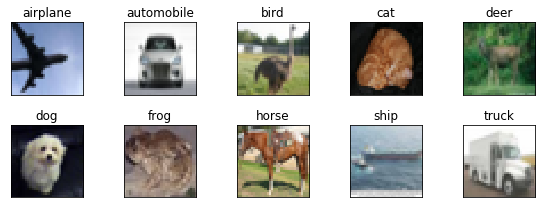

In [4]:
num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(img)
    
plt.tight_layout()

#### Reshaping and normalizing the inputs

In [5]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [6]:
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32)
    X_test = X_test.reshape(X_test.shape[0], 3, 32, 32)
    input_shape = (3, 32, 32)
else:
    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
    X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
    input_shape = (32, 32, 3)
    
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

X_test = np.float32(X_test)
X_test = (X_test / 255 - 0.5) * 2
X_test = np.clip(X_test, -1, 1)

print('X_train reshape:', X_train.shape)
print('X_test reshape:', X_test.shape)

X_train reshape: (50000, 32, 32, 3)
X_test reshape: (10000, 32, 32, 3)


In [7]:
print(X_train[0].shape)

(32, 32, 3)


### 2. Define model

#### Generator


In [8]:
# Number of filters in first layer of generator
gf = 64
k = 3
s = 2

# imagem shape 32x32x3
img_shape = X_train[0].shape

latent_dim = 32*32*3
z = Input(shape=(latent_dim,))
img_g = Reshape(img_shape)(z)

# Downsampling
# Conv 1: 3x3x32 
d1 = Conv2D(gf, kernel_size=k, strides=s, padding='same')(img_g)
d1 = ReLU(0.2)(d1)

# Conv 2: 3x3x64 
d2 = Conv2D(gf*2, kernel_size=k, strides=s, padding='same')(d1)
d2 = BatchNormalization(momentum=0.9)(d2)
d2 = ReLU(0.2)(d2)

# Conv 3: 3x3x128
d3 = Conv2D(gf*4, kernel_size=k, strides=s, padding='same')(d2)
d3 = BatchNormalization(momentum=0.9)(d3)
d3 = ReLU(0.2)(d3)

# Conv 4: 3x3x256
d4 = Conv2D(gf*8, kernel_size=k, strides=s, padding='same')(d3)
d4 = BatchNormalization(momentum=0.9)(d4)
d4 = ReLU(0.2)(d4)

# Upsampling
# Conv 1: 3x3x128 
u1 = Conv2DTranspose(gf*4, kernel_size=k, strides=s, padding='same')(d4)
u1 = BatchNormalization(momentum=0.9)(u1)
u1 = ReLU(0.2)(u1)

# Conv 1: 3x3x64
u2 = Concatenate()([u1, d3])
u2 = Conv2DTranspose(gf*2, kernel_size=k, strides=s, padding='same')(u2)
u2 = BatchNormalization(momentum=0.9)(u2)
u2 = ReLU(0.2)(u2)

# Conv 1: 3x3x32 
u3 = Concatenate()([u2, d2])
u3 = Conv2DTranspose(gf, kernel_size=k, strides=s, padding='same')(u3)
u3 = BatchNormalization(momentum=0.9)(u3)
u3 = ReLU(0.2)(u3)

u4 = Concatenate()([u3, d1])
u4 = Conv2DTranspose(3, kernel_size=k, strides=s, padding='same', activation='tanh')(u4)

generator = Model(z, u4)

#### Generator model visualization

In [9]:
# prints a summary representation of your model
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3072)         0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 32, 32, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   1792        reshape_1[0][0]                  
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 16, 16, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

#### Conditional G model
The prior input noise $p_z(z)$, and $y$ are combined in joint hidden representation.

In [10]:
# Create label embeddings
label = Input(shape=(1,), dtype='int32')
label_embedding = Embedding(num_classes, latent_dim)(label)
label_embedding = Flatten()(label_embedding)

# latent space
z = Input(shape=(latent_dim,))

# Merge inputs (z x label)
input_generator = multiply([z, label_embedding])

# Output image
img = generator(input_generator)

# Generator with condition input
generator = Model([z, label], img, name='generator')

#### Conditional model visualization

In [11]:
# prints a summary representation of your model
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 3072)      30720       input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 3072)         0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3072)         0           embedding_1[0][0]                
__________________________________________________________________________________________________
multiply_1

#### Discriminator

Our discriminator is a simple fully connected neural network with three hidden layer and ReLU activation.

In [12]:
# imagem shape 32x32x3
img_shape = X_train[0].shape
img_shape_flat = 32*32*3

init = initializers.RandomNormal(stddev=0.02)

# Discriminator network
discriminator = Sequential()

discriminator.add(Reshape(X_train[0].shape, input_shape=(img_shape_flat,)))

# Conv 1: 16x16x64
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding='same',
                         kernel_initializer=init))
discriminator.add(LeakyReLU(0.2))

# Conv 2:
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization(momentum=0.9))
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(256, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization(momentum=0.9))
discriminator.add(LeakyReLU(0.2))

# Conv 4: 
discriminator.add(Conv2D(512, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization(momentum=0.9))
discriminator.add(LeakyReLU(0.2))

# FC
discriminator.add(Flatten())

# Output
discriminator.add(Dense(1, activation='sigmoid'))


#### Discriminator model visualization

In [13]:
# prints a summary representation of your model
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 256)         819456    
__________

#### Conditional D model

$x$ and $y$ are presented as inputs

In [14]:
# Embedding condition in input layer

# Create label embeddings
label_d = Input(shape=(1,), dtype='int32')
label_embedding_d = Embedding(num_classes, img_shape_flat)(label_d)
label_embedding_d = Flatten()(label_embedding_d)

# imagem dimension 28x28
img_d = Input(shape=(img_shape_flat,))

# Merge inputs (img x label)
input_discriminator = multiply([img_d, label_embedding_d])

# Output image
validity = discriminator(input_discriminator)

# Discriminator with condition input
discriminator = Model([img_d, label_d], validity, name='discriminator')

#### Conditional model visualization

In [15]:
# prints a summary representation of your model
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 3072)      30720       input_4[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 3072)         0                                            
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 3072)         0           embedding_2[0][0]                
__________________________________________________________________________________________________
multiply_2

### 3. Compile model

#### Compile discriminator

In [16]:
discriminator.compile(Adam(lr=0.0003, beta_1=0.5), loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

#### Combined network

In [17]:
discriminator.trainable = False

fake_img = generator([z, label])
fake_img_flat = Reshape((img_shape_flat, ))(fake_img)
validity = discriminator([fake_img_flat, label])

d_g = Model([z, label], validity, name='adversarial')

d_g.compile(Adam(lr=0.0004, beta_1=0.5), loss='binary_crossentropy',
            metrics=['binary_accuracy'])

In [18]:
# prints a summary representation of your model
d_g.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 3072)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
generator (Model)               (None, 32, 32, 3)    3507907     input_3[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 3072)         0           generator[1][0]                  
__________

### 4. Fit model


epoch = 1/100, d_loss=0.171, g_loss=6.363                                                                                                                         


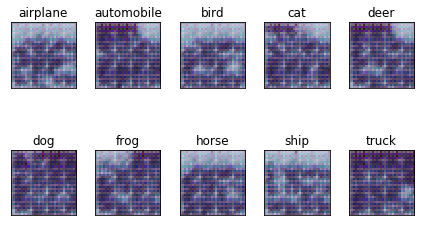

epoch = 2/100, d_loss=0.170, g_loss=4.430                                                                                                                         
epoch = 3/100, d_loss=0.170, g_loss=3.121                                                                                                                         
epoch = 4/100, d_loss=0.257, g_loss=3.415                                                                                                                         
epoch = 5/100, d_loss=0.226, g_loss=3.403                                                                                                                         
epoch = 6/100, d_loss=0.170, g_loss=2.572                                                                                                                         
epoch = 7/100, d_loss=0.173, g_loss=4.394                                                                                                                         
epoch = 8/100, d_loss=

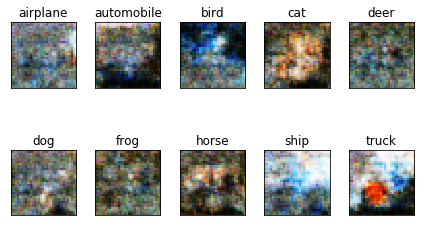

epoch = 12/100, d_loss=0.183, g_loss=2.095                                                                                                                         
epoch = 13/100, d_loss=0.167, g_loss=1.793                                                                                                                         
epoch = 14/100, d_loss=0.177, g_loss=3.617                                                                                                                         
epoch = 15/100, d_loss=0.170, g_loss=4.543                                                                                                                         
epoch = 16/100, d_loss=0.194, g_loss=6.284                                                                                                                         
epoch = 17/100, d_loss=0.209, g_loss=3.434                                                                                                                         
epoch = 18/100, 

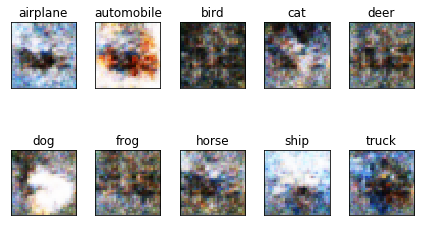

epoch = 22/100, d_loss=0.173, g_loss=2.315                                                                                                                         
epoch = 23/100, d_loss=0.167, g_loss=8.679                                                                                                                         
epoch = 24/100, d_loss=0.164, g_loss=5.423                                                                                                                         
epoch = 25/100, d_loss=0.172, g_loss=2.456                                                                                                                         
epoch = 26/100, d_loss=0.164, g_loss=3.564                                                                                                                         
epoch = 27/100, d_loss=0.194, g_loss=13.942                                                                                                                        
epoch = 28/100, 

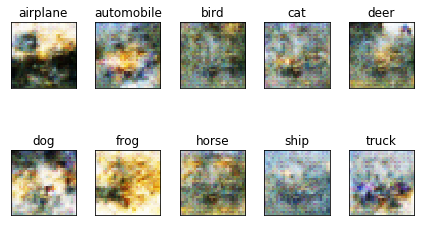

epoch = 32/100, d_loss=0.167, g_loss=3.516                                                                                                                         
epoch = 33/100, d_loss=0.166, g_loss=2.819                                                                                                                         
epoch = 34/100, d_loss=0.168, g_loss=4.644                                                                                                                         
epoch = 35/100, d_loss=0.189, g_loss=8.526                                                                                                                         
epoch = 36/100, d_loss=0.165, g_loss=9.234                                                                                                                         
epoch = 37/100, d_loss=0.166, g_loss=4.567                                                                                                                         
epoch = 38/100, 

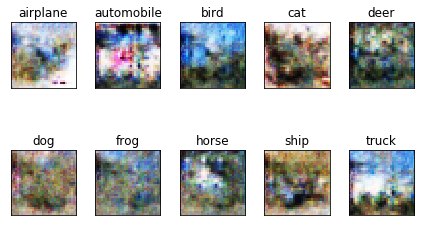

epoch = 42/100, d_loss=0.179, g_loss=2.709                                                                                                                         
epoch = 43/100, d_loss=0.170, g_loss=8.004                                                                                                                         
epoch = 44/100, d_loss=0.166, g_loss=16.037                                                                                                                        
epoch = 45/100, d_loss=0.171, g_loss=5.672                                                                                                                         
epoch = 46/100, d_loss=0.169, g_loss=12.577                                                                                                                        
epoch = 47/100, d_loss=0.175, g_loss=7.441                                                                                                                         
epoch = 48/100, 

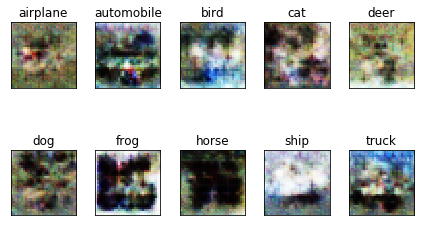

epoch = 52/100, d_loss=0.171, g_loss=5.211                                                                                                                         
epoch = 53/100, d_loss=0.173, g_loss=2.355                                                                                                                         
epoch = 54/100, d_loss=0.165, g_loss=4.902                                                                                                                         
epoch = 55/100, d_loss=0.188, g_loss=5.209                                                                                                                         
epoch = 56/100, d_loss=0.163, g_loss=14.709                                                                                                                        
epoch = 57/100, d_loss=0.173, g_loss=6.418                                                                                                                         
epoch = 58/100, 

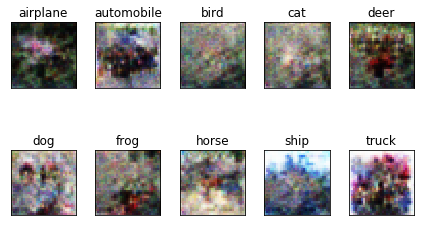

epoch = 62/100, d_loss=0.170, g_loss=16.118                                                                                                                        
epoch = 63/100, d_loss=0.163, g_loss=14.948                                                                                                                        
epoch = 64/100, d_loss=0.167, g_loss=14.250                                                                                                                        
epoch = 65/100, d_loss=0.166, g_loss=4.127                                                                                                                         
epoch = 66/100, d_loss=0.165, g_loss=15.669                                                                                                                        
epoch = 67/100, d_loss=0.164, g_loss=10.928                                                                                                                        
epoch = 68/100, 

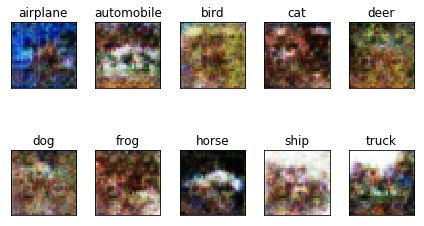

epoch = 72/100, d_loss=0.168, g_loss=13.990                                                                                                                        
epoch = 73/100, d_loss=0.164, g_loss=12.888                                                                                                                        
epoch = 74/100, d_loss=0.165, g_loss=9.369                                                                                                                         
epoch = 75/100, d_loss=0.171, g_loss=2.837                                                                                                                         
epoch = 76/100, d_loss=0.165, g_loss=5.511                                                                                                                         
epoch = 77/100, d_loss=0.164, g_loss=16.118                                                                                                                        
epoch = 78/100, 

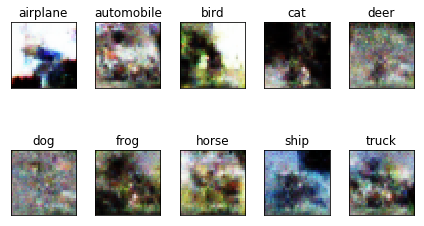

epoch = 82/100, d_loss=0.168, g_loss=13.167                                                                                                                        
epoch = 83/100, d_loss=0.166, g_loss=5.098                                                                                                                         
epoch = 84/100, d_loss=0.164, g_loss=9.451                                                                                                                         
epoch = 85/100, d_loss=0.166, g_loss=8.713                                                                                                                         
epoch = 86/100, d_loss=0.169, g_loss=8.751                                                                                                                         
epoch = 87/100, d_loss=0.164, g_loss=9.683                                                                                                                         
epoch = 88/100, 

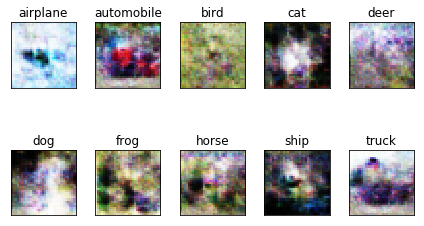

epoch = 92/100, d_loss=0.168, g_loss=9.309                                                                                                                         
epoch = 93/100, d_loss=0.164, g_loss=12.097                                                                                                                        
epoch = 94/100, d_loss=0.188, g_loss=8.163                                                                                                                         
epoch = 95/100, d_loss=0.165, g_loss=12.478                                                                                                                        
epoch = 96/100, d_loss=0.165, g_loss=15.992                                                                                                                        
epoch = 97/100, d_loss=0.163, g_loss=6.396                                                                                                                         
epoch = 98/100, 

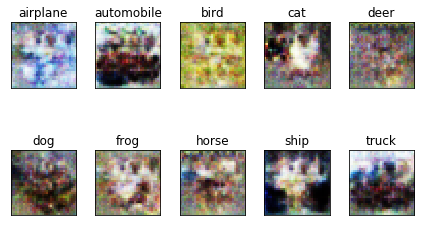

In [19]:
epochs = 100
batch_size = 32
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        real_labels = y_train[i*batch_size:(i+1)*batch_size].reshape(-1, 1)
        
        d_loss_real = discriminator.train_on_batch(x=[X_batch.reshape(-1, 32*32*3), real_labels],
                                                   y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        X_fake = generator.predict_on_batch([z, random_labels])
        
        d_loss_fake = discriminator.train_on_batch(x=[X_fake.reshape(-1, 32*32*3), random_labels], y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        d_g_loss_batch = d_g.train_on_batch(x=[z, random_labels], y=real)
   
        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
        labels = np.arange(0, 10).reshape(-1, 1)
        
        x_fake = generator.predict([z, labels])
        x_fake = np.clip(x_fake, -1, 1)
        x_fake = (x_fake + 1) * 127
        x_fake = np.round(x_fake).astype('uint8')

        for k in range(samples):
            plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
            plt.imshow(x_fake[k])
            plt.title(class_names[k])

        plt.tight_layout()
        plt.show()

### 5. Evaluate model

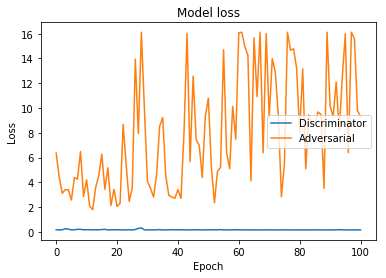

In [20]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()

## References

* [Conditional Generative Adversarial Nets](https://arxiv.org/pdf/1411.1784.pdf)
* [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)
* [THE MNIST DATABASE of handwritten digits](http://yann.lecun.com/exdb/mnist/)
* [Keras-GAN](https://github.com/eriklindernoren/Keras-GAN)